<a href="https://colab.research.google.com/github/ftornay/TFG/blob/master/A/IAPS_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision import *
%matplotlib inline
# No hace falta importar matplotlib, ya lo hace fastai
import statsmodels.api as sm
import scipy as sp

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Activar drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Leemos los datos del disco
iaps_path = Path("/content/drive/MyDrive/IAPS")
# Salen advertencias de fastai
# Las ignoramos
import warnings
warnings.filterwarnings("ignore")
data = load_data(iaps_path, 'iaps_db.pkl').normalize(imagenet_stats)

In [ ]:
# Cargamos el "learner" con los pesos grabados
learn = cnn_learner(data, models.resnet34, pretrained=False)
# Pongo ; para que no imprima toda la estructura del learner
learn.load(iaps_path/'stage_2');

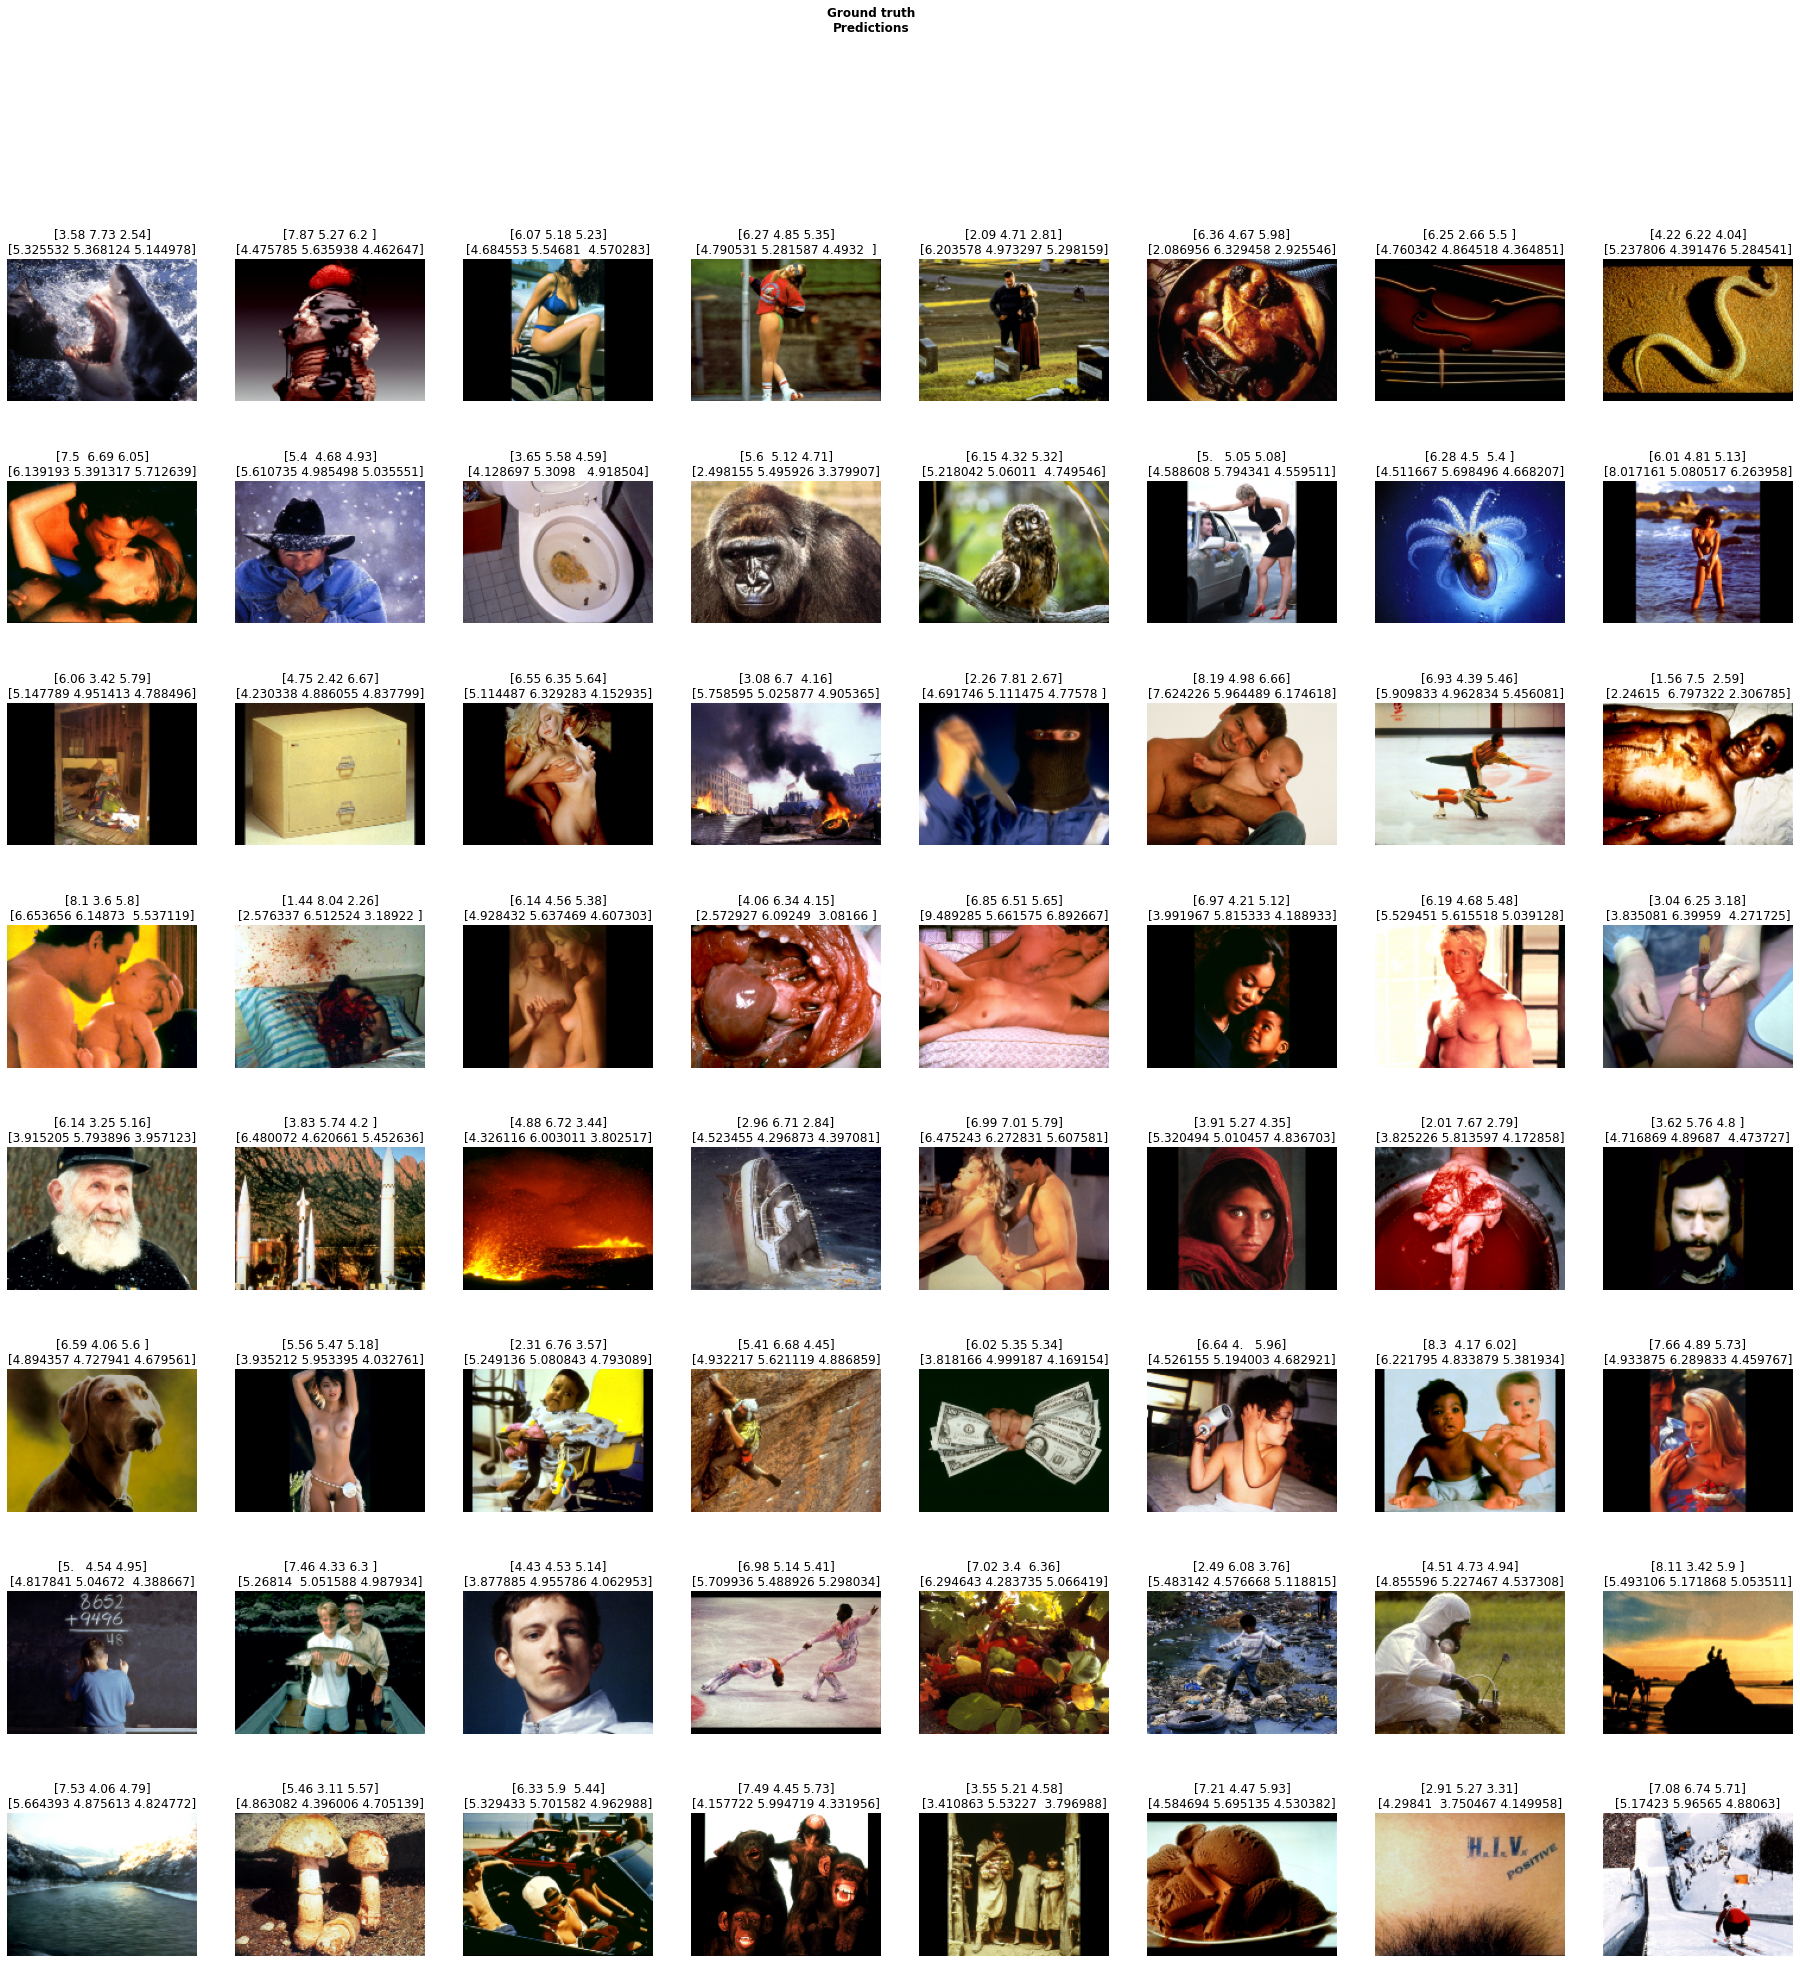

In [ ]:
# Muestra 10 filas de resultados y los graba en disco
learn.show_results(rows=10)
plt.savefig(iaps_path/'results.jpg')

In [ ]:
# Tomamos los datos del learner
# Predicciones y reales
valid_preds, valid_real = learn.get_preds()
train_preds, train_real = learn.get_preds(DatasetType.Train)

In [ ]:
# Forma de los datos
valid_preds.shape, valid_real.shape, train_preds.shape, train_real.shape

(torch.Size([161, 3]),
 torch.Size([161, 3]),
 torch.Size([640, 3]),
 torch.Size([640, 3]))

In [ ]:
# Cada conjunto de datos tiene los valores de valencia (índice 0), arousal (índice 1) y dominancia (índice 2)
# Conviene convertirlos a arreglos de numpy para analizarlos
# Por ejemplo, estos serían los datos predichos y reales de valencia para el conjunto de validación
val_valid_pred = valid_preds[:,0].numpy()
val_valid_real = valid_real[:,0].numpy()
val_valid_pred, val_valid_real

(array([5.325532, 4.475785, 4.684553, 4.790531, ..., 3.992415, 4.710877, 3.983123, 4.127047], dtype=float32),
 array([3.58, 7.87, 6.07, 6.27, ..., 7.43, 4.27, 3.48, 4.21], dtype=float32))

In [ ]:
# Igual para activación y dominancia
act_valid_pred = valid_preds[:,1].numpy()
act_valid_real = valid_real[:,1].numpy()
dom_valid_pred = valid_preds[:,2].numpy()
dom_valid_real = valid_real[:,2].numpy()

In [ ]:
# Análisis de regresión
# Tomamos val_valid_real como Y
# y val_valid_pred como X
# Necesitamos añadir un cruce con ordenada a X y tomarlo como nuevo X
Y = val_valid_real
X = val_valid_pred
XA = sm.add_constant(X)
model_val = sm.OLS(Y, XA)
results_val = model_val.fit()
results_val.params

array([2.192387, 0.612707])

In [ ]:
# Guardamos los parámetros para la gráfica
a, m = results_val.params[0], results_val.params[1]

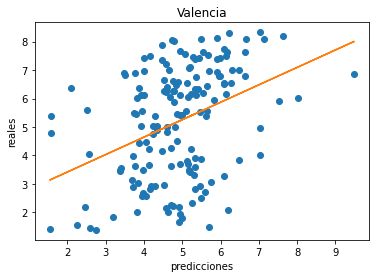

In [ ]:
# Diagrama de dispersión
plt.plot(X, Y, 'o')
# Con línea de mejor ajuste
plt.plot(X, m*X+a)
# Ponemos título y etiquetamos los ejes
plt.title('Valencia')
plt.xlabel('predicciones')
plt.ylabel('reales')
# Guardamos el gráfico, el parámetro dpi permite ajustar la resolución
plt.savefig('Valencia.png')

In [ ]:
# Análisis estadístico
print("Grados de libertad: ", results_val.df_model, results_val.df_resid)
results_val.summary()

Grados de libertad:  1.0 159.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     26.88
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           6.50e-07
Time:                        01:24:36   Log-Likelihood:                -322.82
No. Observations:                 161   AIC:                             649.6
Df Residuals:                     159   BIC:                             655.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1924      0.593      3.694      0.000       1.020       3.364
x1             0.6127      0.118      5.185      0.000       0.379       0.846
==============================================================================
Omnibus:                       31.359   Durbin-Watson:                   2.176
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.743
Skew:                          -0.320   Prob(JB):                      0.00766
Kurtosis:                       1.979   Cond. No.                         21.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

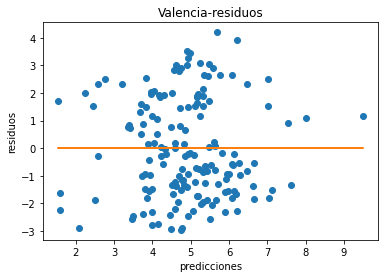

In [ ]:
# Gráfica de residuos
# para comprobar los supuestos del análisis de regresión
# Esperamos residuos distribuidos aleatoramiente en torno a 0
# Sin patrones sistemáticos
# y con la misma dispersión aproximada para todos los valores de X
resids_val = results_val.fittedvalues - val_valid_real
plt.title('Valencia-residuos')
plt.xlabel('predicciones')
plt.ylabel('residuos')
plt.plot(X, resids_val, 'o')
plt.plot(X, 0*X);

0.9597148725548309

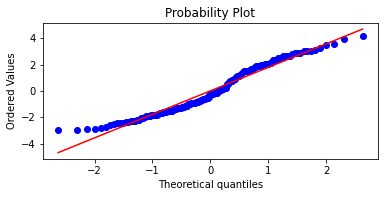

In [ ]:
# Normalidad de los residuos
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(resids_val, plot=ax, fit=True)
# Una r2 cercana a uno indica que los residuos siguen una distribución
# aproximadamente normal (se cumple el supuesto)
r**2

In [ ]:
Y2 = act_valid_real
X2 = act_valid_pred
X2A = sm.add_constant(X2)
model_act = sm.OLS (Y2, X2A)
results_act = model_act.fit()
results_act.params

array([0.715505, 0.843713])

In [ ]:
# Guardamos los parámetros para la gráfica
a2, m2 = results_act.params[0], results_act.params[1]

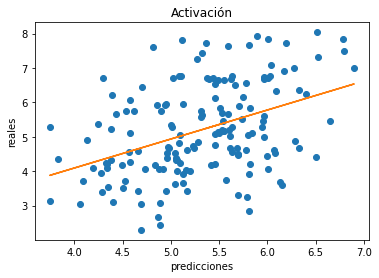

In [ ]:
# Diagrama de dispersión
plt.plot(X2, Y2, 'o')
# Con línea de mejor ajuste
plt.plot(X2, m2*X2+a2)
# Ponemos título y etiquetamos los ejes
plt.title('Activación')
plt.xlabel('predicciones')
plt.ylabel('reales')
# Guardamos el gráfico, el parámetro dpi permite ajustar la resolución
plt.savefig('Activación.png')

In [ ]:
# Análisis estadístico
print("Grados de libertad: ", results_act.df_model, results_act.df_resid)
results_act.summary()

Grados de libertad:  1.0 159.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     33.78
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           3.28e-08
Time:                        01:25:28   Log-Likelihood:                -258.86
No. Observations:                 161   AIC:                             521.7
Df Residuals:                     159   BIC:                             527.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7155      0.776      0.922      0.358      -0.818       2.249
x1             0.8437      0.145      5.812      0.000       0.557       1.130
==============================================================================
Omnibus:                        4.175   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.124   Jarque-Bera (JB):                2.727
Skew:                           0.127   Prob(JB):                        0.256
Kurtosis:                       2.415   Cond. No.                         44.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

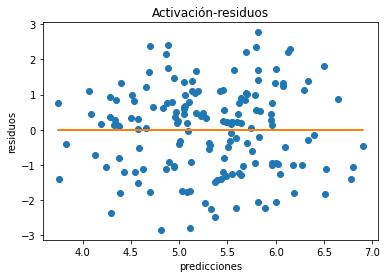

In [ ]:
# Gráfica de residuos
# para comprobar los supuestos del análisis de regresión
# Esperamos residuos distribuidos aleatoramiente en torno a 0
# Sin patrones sistemáticos
# y con la misma dispersión aproximada para todos los valores de X
resids_act = results_act.fittedvalues - act_valid_real
plt.title('Activación-residuos')
plt.xlabel('predicciones')
plt.ylabel('residuos')
plt.plot(X2, resids_act, 'o')
plt.plot(X2, 0*X2);

0.9893413435181587

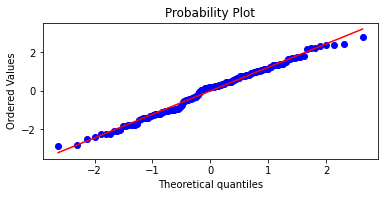

In [ ]:
# Normalidad de los residuos
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(resids_act, plot=ax, fit=True)
# Una r2 cercana a uno indica que los residuos siguen una distribución
# aproximadamente normal (se cumple el supuesto)
r**2

In [ ]:
Y3 = dom_valid_real
X3 = dom_valid_pred
X3A = sm.add_constant(X3)
model_dom = sm.OLS (Y3, X3A)
results_dom = model_dom.fit()
results_dom.params

array([2.117532, 0.593744])

In [ ]:
# Guardamos los parámetros para la gráfica
a3, m3 = results_dom.params[0], results_dom.params[1]

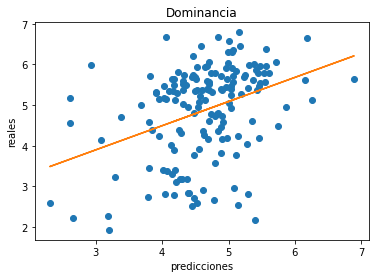

In [ ]:
# Diagrama de dispersión
plt.plot(X3, Y3, 'o')
# Con línea de mejor ajuste
plt.plot(X3, m3*X3+a3)
# Ponemos título y etiquetamos los ejes
plt.title('Dominancia')
plt.xlabel('predicciones')
plt.ylabel('reales')
# Guardamos el gráfico, el parámetro dpi permite ajustar la resolución
plt.savefig('Dominancia.png')

In [ ]:
# Análisis estadístico
print("Grados de libertad: ", results_dom.df_model, results_dom.df_resid)
results_dom.summary()

Grados de libertad:  1.0 159.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     24.46
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           1.91e-06
Time:                        01:26:18   Log-Likelihood:                -238.10
No. Observations:                 161   AIC:                             480.2
Df Residuals:                     159   BIC:                             486.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1175      0.563      3.761      0.000       1.006       3.229
x1             0.5937      0.120      4.946      0.000       0.357       0.831
==============================================================================
Omnibus:                       11.069   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               12.113
Skew:                          -0.661   Prob(JB):                      0.00234
Kurtosis:                       2.762   Cond. No.                         32.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

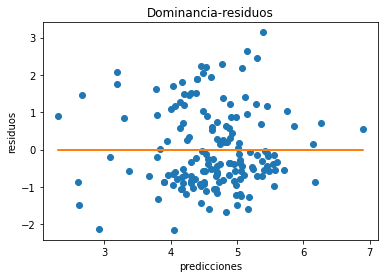

In [ ]:
# Gráfica de residuos
# para comprobar los supuestos del análisis de regresión
# Esperamos residuos distribuidos aleatoramiente en torno a 0
# Sin patrones sistemáticos
# y con la misma dispersión aproximada para todos los valores de X
resids_dom = results_dom.fittedvalues - dom_valid_real
plt.title('Dominancia-residuos')
plt.xlabel('predicciones')
plt.ylabel('residuos')
plt.plot(X3, resids_dom, 'o')
plt.plot(X3, 0*X3);

0.9507172964261058

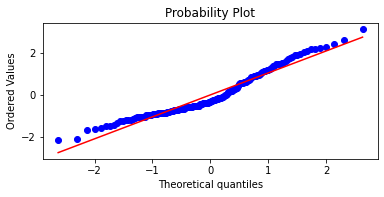

In [ ]:
# Normalidad de los residuos
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(resids_dom, plot=ax, fit=True)
# Una r2 cercana a uno indica que los residuos siguen una distribución
# aproximadamente normal (se cumple el supuesto)
r**2